In [89]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.constants as constants
from scipy.integrate import quad
from astropy.wcs import WCS
from mgefit.find_galaxy import find_galaxy
import pyarrow.parquet as pq
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.spatial import cKDTree

作业16

如果某质量为m的天体，从无穷远处到被黑洞吸积到最小稳定轨道（3Rs），释放的能量是多少?

In [ ]:
#Rs = 2GM/c2
#delta_E = 0 - (-GMm/3Rs) = GMm/3Rs
delta_E = mc^2/6 #释放的能量为mc^2/6

In [ ]:
# 动能等于势能的一半

如果一个星系中的AGN光度超过恒星光度，其黑洞质量与恒星质量的比值最低是多少？

• 假设该星系恒星质量的质光比~3M☉/L☉，


In [ ]:
#LAGN = Lstar
#Mstar = 3*Lstar
#Lstar = Mstar/3
#LAGN = 30000*MBH #LE = 30000*Lsun*M/Msun
#MBH = LAGN/30000
#MBH = Mstar/90000
MBH/Mstar = 1/90000 #最低为1/90000

作业17

对于作业5中的星系（或选择一个新的低红移星系），将其人为放置到更高红移处，生成在同样望远镜观测中的图像（可选多波段，并考虑K改正效应）。


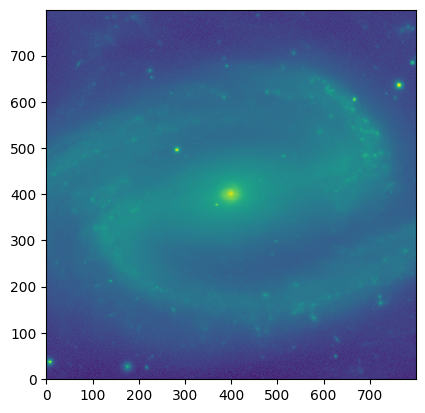

In [ ]:
path = './NGC1300_DESI_R.fits'
hdu_list = fits.open(path, cache=True)
img = hdu_list[0].data/0.75/0.75 #L/arcsec^2
plt.imshow(np.log10(img),origin='lower')


566.82336
566.82336
将NGC1300放到红移为1处时，如下图所示


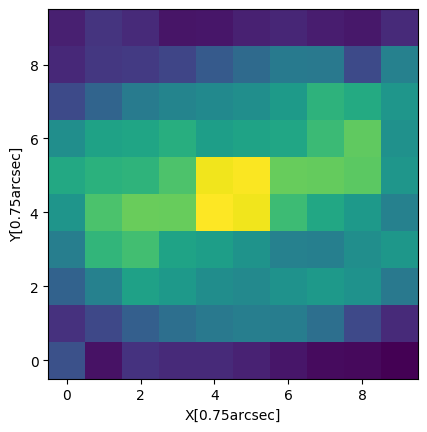

In [39]:
z = 0.005264#from NED
c = 3*1e5 #km/s
H0 = 70    
V = z*c   #km/s
Distance = V/H0  #Mpc
arctkpc = Distance/1e3*np.pi/0.648  # 1 arcsecond corresponding to kpc  

H0 = 70
omegaM = 0.05
omegak = 0.25
omegalamda = 0.7


z1 = 1 #移到红移=1

dH = c/H0 #Mpc

def getdc(z):
    return dH/np.sqrt(omegaM*(1+z)*(1+z)*(1+z)+omegak*(1+z)*(1+z)+omegalamda)

dC, error = quad(getdc, 0, z1) 
dL = dC*(1+z1)
dA = dC/(1+z1)

img1 = img/(4*np.pi)*(1/((1+z1)**4))
index = dA/Distance

from PIL import Image
original_image = Image.fromarray(img1)
target_size = (int(img1.shape[0]/index), int(img1.shape[1]/index))
resized_image = original_image.resize(target_size, Image.BILINEAR)
resized_image = resized_image/np.sum(resized_image)
resized_img = resized_image * np.sum(img1)

plt.imshow(np.log10(resized_img),origin='lower')
plt.xlabel('X[0.75arcsec]')
plt.ylabel('Y[0.75arcsec]')
print(np.sum(img1))
print(np.sum(resized_img))

print('将NGC1300放到红移为1处时，如下图所示')


#先resize（流量守恒），后表面亮度下降（没有4pi）更简单

作业18

对于作业5或者作业15中的星系，采取至少一种方法来（定量）评估该星系所处的环境

 Pixels used: 15366
 Peak Img[j, k]: 400 400
 Mean (j, k): 399.26 399.04
 Theta (deg): 168.6
 Astro PA (deg): 101.4
 Eps: 0.437
 Major axis (pix): 98.8
<SkyCoord (ICRS): (ra, dec) in deg
    (49.92098624, -19.4111255)>


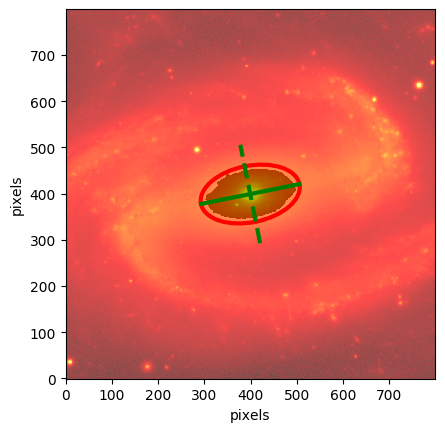

In [4]:
#获得NGC1300的中心
def pix2radec_legacy(x,y):
    xcen_ra_ip = y
    ycen_dec_ip = x
    file = './NGC1300_DESI_R.fits'
    f = fits.open(file)
    w = WCS(f[0].header)
    sky = w.pixel_to_world(xcen_ra_ip,ycen_dec_ip)   
    print(sky) 
path = './NGC1300_DESI_R'
hdu_list = fits.open(path+'.fits', cache=True)
img = hdu_list[0].data
f = find_galaxy(img, fraction=0.03, plot=1)
xcen = f.xpeak
ycen = f.ypeak
pix2radec_legacy(xcen,ycen)

In [121]:
z = 0.005264#from NED
c = 3*1e5 #km/s
H0 = 70    
V = z*c   #km/s
Distance = V/H0  #Mpc
arctkpc = Distance/1e3*np.pi/0.648  # 1 arcsecond corresponding to kpc  
Distance_1 = Distance+1 #纵向方向至少在1Mpc以内
Distance_2 = Distance-1 #纵向方向至少在1Mpc以内
V_1 = Distance_1*H0
z_1 = V_1/c

V_2 = Distance_2*H0
z_2 = V_2/c
print('红移小于',z_1)
print('红移大于',z_2)

红移小于 0.005497333333333332
红移大于 0.005030666666666666


In [6]:
#读取DESI的catalog
path = '/data/rscai/SDSS_HSC_DESIrealgal/gz_desi_deep_learning_catalog_advanced.parquet'
parquet_file = pq.ParquetFile(path)
table = parquet_file.read()

path_1 = '/data/rscai/SDSS_HSC_DESIrealgal/external_catalog.parquet'
parquet_file_1 = pq.ParquetFile(path_1)
table_1 = parquet_file_1.read()


In [ ]:
RA = table.column('ra')
DEC = table.column('dec')

redshift_spc_z = table_1.column('spec_z')

RA = np.array(RA)
DEC = np.array(DEC)

redshift_spc_z = np.array(redshift_spc_z)

#选择小于z1,大于z2的星系
index = np.where((redshift_spc_z<z_1)&(redshift_spc_z>z_2))[0]

In [ ]:
def match(df_1, df_2):
    
    ngc1300 = SkyCoord(ra=df_1.ra, dec=df_1.dec, unit=u.arcsec)
    decals = SkyCoord(ra=df_2.ra, dec=df_2.dec, unit=u.arcsec)
    idx, d2d, d3d = ngc1300.match_to_catalog_sky(decals)
    
    z_df = np.array(df_1.z)
    
    #求本地到NGC1300的距离和到另一个星系的距离
    z = 0.005264#from NED
    c = 3*1e5 #km/s
    H0 = 70    
    V = z*c   #km/s
    Distance = V/H0  #Mpc
    arctkpc = Distance/1e3*np.pi/0.648  # 1 arcsecond corresponding to kpc  
    V_df = z_df*c   #km/s
    Distance_df = V_df/H0  #Mpc
    

    
    #求本地到NGC1300的距离和到另一个星系的夹角
    RA1 = np.array(df_1.ra)*np.pi/180
    DEC1 = np.array(df_1.dec)*np.pi/180    
    RA2 = np.array(df_2.ra)*np.pi/180
    DEC2 = np.array(df_2.dec)*np.pi/180
    cos_theta = np.sin(DEC1)*np.sin(DEC2)+np.cos(DEC1)*np.cos(DEC2)*np.cos(RA2-RA1)

    #已知两边和夹角，利用三角公式求这两个星系的距离
    Final_distance = np.sqrt(Distance**2+Distance_df**2-2*Distance*Distance_df*cos_theta)
       
    return Final_distance


In [136]:
DESI = {'ra':RA[index],'dec':DEC[index],'z':redshift_spc_z[index]}
DESI = pd.DataFrame(DESI)

In [ ]:
def process():
    NGC1300 = {'ra':[49.92098624],'dec':[-19.4111255]}
    NGC1300 = pd.DataFrame(NGC1300)
    Final_distance = match(DESI[["ra", "dec",'z']], NGC1300[["ra", "dec"]])
    return Final_distance

In [138]:
Final_distance = process()

In [146]:
tree = cKDTree(np.c_[Final_distance.ravel()])
dd, ii = tree.query([[0]], k=32)
print(dd)
print('到最近邻星系的距离为: {:.1f} Mpc'.format(dd[0][0]))
print('NGC1300是isolated galaxy')

[[ 7.11050234  7.17783348  7.19018537  7.34353273  7.43974041  8.21565739
   9.2615329   9.60676754 10.08043829 10.18374249 10.45799047 10.96364455
  11.62645098 11.68209801 11.9713605  11.99248957 12.60550687 12.61430167
  12.71759012 12.76973627 12.80930541 12.90748236 13.14978156 13.27308246
  13.39394157 13.44444126 13.58044871 13.60089644 13.88800041 14.1083287
  15.37737565 16.0641962 ]]
到最近邻星系的距离为: 7.1 Mpc
NGC1300是isolated galaxy


In [ ]:
# 这个算法是错的，红移差反应的是速度不是距离